### Домашнее задание Transformers Training (50 баллов)

В этом домашнем задании требуется обучить несколько Transformer-based моделей в задаче машинного перевода. Для обучения можно воспользоваться текущим проектом, так и реализовать свой пайплайн обучения. Если будете использовать проект, теги **TODO** проекта отмечают, какие компоненты надо реализовать.
В ноутбуке нужно только отобразить результаты обучения и выводы. Архитектура модели(количество слоев, размерность и тд) остается на ваш выбор.

Ваш код обучения нужно выложить на ваш github, в строке ниже дать ссылку на него. В первую очередь будут оцениваться результаты в ноутбуке, код нужен для проверки адекватности результатов. 

Обучать модели до конца не нужно, только для демонстрации, что модель обучается и рабочая - снижение val_loss, рост bleu_score.

#### Сcылка на ваш github с проектом (ветка hw) - https://github.com/DmitryInd/pytorch-machine-translation/tree/hw

Ноутбук с результатами выкладывать на ваш **google диск** курса. 

### Данные

`
wget https://www.manythings.org/anki/rus-eng.zip && unzip rus-eng.zip
`

Модели нужно обучить на задаче перевода с английского на русский.

In [1]:
# !wget https://www.manythings.org/anki/rus-eng.zip && unzip rus-eng.zip

### Вспомогательные функции

In [2]:
# %pip install sentencepiece torchtext huggingface-hub transformers tokenizer

In [3]:
#!g1.1
# Кажется, у меня проблемы с драйверами для видеокарты, из-за чего обучение может в произвольный момент падать
# Запрет асинхронных запусков ядра не решает проблему полностью, но заметно снижает вероятность её возникновения
# import os
# os.environ['CUDA_LAUNCH_BLOCKING']="1"

In [4]:
#!g1.1
import torch
import numpy as np

if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'

In [5]:
#!g1.1
def print_learning_parameters(data_config, model_config):
    print(f"Parameters of the model:")
    print(f"* Learning rate is {model_config['learning_rate']}.")
    if 'div_factor' in model_config:
        print(f"* OneCycleLR with warm up and linear decrease of learning rate to division factor {model_config['div_factor']} is in use.")
    else:
        print("* Adafactor with constant learning rate is in use.")
    print(f"* Batch size is {data_config['batch_size']}.")
    if data_config['pretrained_input_tokenizer_name'] is not None:
        print(f"* The tokenizer for input values uses the pretrained vocabulary from '{data_config['pretrained_input_tokenizer_name']}'.")
    if data_config['pretrained_output_tokenizer_name'] is not None:
        print(f"* The tokenizer for output values uses the pretrained vocabulary from '{data_config['pretrained_output_tokenizer_name']}'.")
    print(f"* The number of epochs is {model_config['epoch_num']}.")
    if "pretrained_model_name" in model_config:
        print(f"* Pretrained parameters from '{model_config['pretrained_model_name']}' is used.")
    if 'emb_size' in model_config:
        print(f"* The size of embeddings/hidden states is {model_config['emb_size']}.")
    if 'num_encoder_layers' in model_config and 'num_decoder_layers' in model_config:
        print(f"* The numbers of encoder and decoder layers are {model_config['num_encoder_layers']} and {model_config['num_decoder_layers']}.")
    if 'num_heads' in model_config:
        print(f"* There are {model_config['num_heads']} heads for self-attention and encoder-decoder attention")

In [6]:
#!g1.1
import re
import matplotlib.pylab as plt

MATCH_REGEX = re.compile(r"[+-]?\b(\d+([.]\d*)?([eE][+-]?\d+)?|[.]\d+([eE][+-]?\d+)?)\b")

def extract_values(string):
    result = dict()
    params = ['val_loss', 'train_loss', 'bleu_score']
    if "train_loss" in string:
        found_vals = [re_match[0] for re_match in re.findall(MATCH_REGEX, string)]

        if len(params) == len(found_vals):
            for name, val in zip(params, found_vals):
                result[name] = float(val)
    return result

def plot_results(train_loss_list, val_loss_list, val_bleu_list, run_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    ax1.plot(range(len(train_loss_list)), train_loss_list, label='train loss')
    ax1.plot(range(len(val_loss_list)), val_loss_list, label='val loss')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.legend()

    ax2.plot(range(len(val_bleu_list)), val_bleu_list, label='val bleu')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('BLEU')
    ax2.legend()

    fig.suptitle(run_name, fontsize=20)
    plt.show()

In [7]:
#!g1.1
def print_demo_translations(model, val_dataloader, input_tokenizer, sentence_num=10):
    input_tensor, target_tensor = val_dataloader.__iter__().__next__()
    input_tensor = input_tensor[:sentence_num]
    target_tensor = target_tensor[:sentence_num]
    with torch.no_grad():
        predicted_samples, _ = model.forward(input_tensor)
    bleu_score, actual_sentences, predicted_sentences = model.eval_bleu(predicted_samples, target_tensor)
    print(f'BLEU score on the following sentences is {bleu_score}.')
    print("* Original sentence\t| True translation\t| Predicted translation")
    for in_tens, actual, pred in zip(input_tensor, actual_sentences, predicted_sentences):
        print(f"* {' '.join(input_tokenizer.decode(in_tens.tolist()))}\t| {actual}\t| {pred}")
    print('##############################')

In [8]:
#!g1.1
import sys  
sys.path.insert(1, "./src")

### Обучение Seq2seq Transformer модель(25 баллов)

Реализуйте Seq2seq Transformer. В качестве блока трансформера можно использовать https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html. В качестве токенизатора воспользуйтесь HuggingFace токенизатор для source/target языков - https://huggingface.co/docs/transformers/fast_tokenizers
В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов. 

Не забудьте остальные элементы модели:
* Мы можем использовать 1 трансформер как энкодер - декодером будет выступать линейный слой. 
* Обучите свой BPE токенизатор - https://huggingface.co/docs/transformers/fast_tokenizers
* Матрицу эмбеддингов токенов
* Матрицу позиционных эмбеддингов
* Линейный слой проекции в target словарь
* Функцию маскирования будущих состояний attention, так как модель авто-регрессионна
* Learning rate scheduler


В качестве результатов, приложите следующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, размерность скрытого слоя, количество слоев
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

In [9]:
#!g1.1
import yaml
from models import trainer
from data.datamodule import DataManager
from txt_logger import TXTLogger
from models.seq2seq_transformer import Seq2SeqTransformer
from models.seq2seq_t5 import Seq2SeqT5

### Конфигурация модели и алгоритма обучения

In [10]:
#!g1.1
transformer_data_config = yaml.load(open("configs/data_config.yaml", 'r'), Loader=yaml.Loader)
transformer_model_config = yaml.load(open("configs/transformer_config.yaml", 'r'), Loader=yaml.Loader)
print_learning_parameters(transformer_data_config, transformer_model_config)

Parameters of the model:
* Learning rate is 0.0001.
* OneCycleLR with warm up and linear decrease of learning rate to division factor 10000 is in use.
* Batch size is 256.
* The number of epochs is 5.
* The size of embeddings/hidden states is 510.
* The numbers of encoder and decoder layers are 4 and 4.
* There are 6 heads for self-attention and encoder-decoder attention


### Обучение модели

In [11]:
#!g1.1
tran_dm = DataManager(transformer_data_config, DEVICE)
tran_train_dataloader, tran_val_dataloader = tran_dm.prepare_data()

transformer = Seq2SeqTransformer(
    device=DEVICE,
    encoder_vocab_size=len(tran_dm.source_tokenizer.index2word),
    decoder_vocab_size=len(tran_dm.target_tokenizer.index2word),
    target_tokenizer=tran_dm.target_tokenizer,
    start_symbol=tran_dm.target_tokenizer.sos_token,
    lr=transformer_model_config['learning_rate'],
    total_steps=transformer_model_config['epoch_num']*len(tran_train_dataloader),
    emb_size=transformer_model_config['emb_size'],
    num_heads=transformer_model_config['num_heads'],
    num_encoder_layers=transformer_model_config['num_encoder_layers'],
    num_decoder_layers=transformer_model_config['num_decoder_layers'],
    dropout=transformer_model_config['dropout'],
    div_factor=transformer_model_config['div_factor']
)

tran_logger = TXTLogger(transformer_model_config['path_to_log'])
tran_trainer_cls = trainer.Trainer(model=transformer, model_config=transformer_model_config, logger=tran_logger)

if transformer_model_config['try_one_batch']:
    tran_train_dataloader = [list(tran_train_dataloader)[0]]
    tran_val_dataloader = [list(tran_val_dataloader)[0]]

tran_trainer_cls.train(tran_train_dataloader, tran_val_dataloader)

Reading from file: 100%|██████████| 467119/467119 [00:08<00:00, 52106.06it/s]








Current BLEU:  0.015352623994219841
тебя действительно выперли из команды ---> ты действительно очень на на
я и не думал что ещё увижу тома живым ---> я никогда не что я я том тома тома
будем надеяться что это в последний раз ---> давай что это это это это это
том собирается в следующие выходные в бостон ---> том будет в бостон в бостон бостон бостон
том сказал мне что мне нужно быть более напористым ---> том сказал мне мне мне мне нужно быть
##############################
Current BLEU:  0.04140174390343821
том сказал что может подождать до половины третьего ---> том сказал что может может ждать
вода стала грязной из за дождя ---> вода дождь дождь дождь дождь
не думаю что из тома вышел бы очень хороший начальник ---> не думаю что том том очень хороший
она отсутствовала в школе по болезни ---> она была из из из из
не знаю как мы с этим справимся ---> я не знаю как мы
##############################
Current BLEU:  0.042666374304112756
школа находится в пяти минутах ходьбы от станции

In [12]:
#!g1.1
import os
file_content = open(os.path.join(transformer_model_config['path_to_log'], "progress_log.txt"), 'r').read().split("\n")
tran_train_loss_list, tran_val_loss_list, tran_val_bleu_list = [], [], []
for line in file_content:
    d = extract_values(line)
    if len(d) > 0:
        tran_train_loss_list.append(d['train_loss'])
        tran_val_loss_list.append(d['val_loss'])
        tran_val_bleu_list.append(d['bleu_score'])

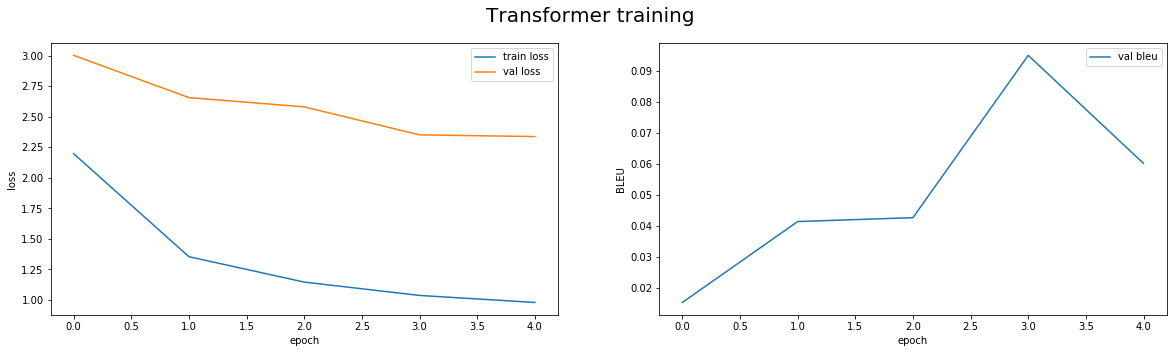

In [13]:
#!g1.1
plot_results(tran_train_loss_list, tran_val_loss_list, tran_val_bleu_list, run_name='Transformer training')

### Итоговое качество модели/примеры переводов

In [23]:
#!g1.1
print(f"Final BLUE score is {tran_val_bleu_list[-1]}.")
print(f"The best BLUE score is {max(tran_val_bleu_list)} on {np.argmax(tran_val_bleu_list) + 1} epoch.")

Final BLUE score is 0.06013214404387736.
The best BLUE score is 0.09493957646214518 on 4 epoch.


In [15]:
#!g1.1
print_demo_translations(transformer, tran_val_dataloader, tran_dm.source_tokenizer)

BLEU score on the following sentences is 0.0.
* Original sentence	| True translation	| Predicted translation
* he satisfied his thirst with a large glass of beer	| он утолил жажду большим стаканом пива	| он доволен с с с с
* tom anticipated that there would be trouble	| том предчувствовал беду	| том тома там там там было было
* tom and mary went to the beach by bicycle	| том и мэри поехали на велосипедах на пляж	| том и мэри пошли на на на на
* my father exercises every day for his health	| мой отец каждый день занимается для своего здоровья	| мой отец каждый каждый день день
* the year before last we went to europe	| в позапрошлом году мы ездили в европу	| в год до до в в в в
* you can stay here till the snow stops	| ты можешь остаться здесь пока снег не перестанет	| можешь остаться здесь здесь до до
* do you know how to convert from celsius to fahren	| ты умеешь переводить цельсии в фаренгейты	| ты знаешь как от от от от от
* i promise i ll mop the floor tomorrow morning	| я обещаю ч

### Fine-tune pretrained T5 (25 баллов)

Реализуйте Seq2seq Pretrained T5. Воспользуйтесь https://huggingface.co/docs/transformers/model_doc/t5 предобученной моделью. В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов. Архитектура модели(количество слоев, размерность и тд) остается на ваш выбор.

Не забудьте важные аспекты обучения модели:
* Взять готовый t5 токенизатор
* Resize matrix embedding - скорей всего ваша матрица эмбеддингов не будет включать эмбеддинги из вашего сета. Пример обновления матрицы эмбеддингов тут тут https://github.com/runnerup96/Transformers-Tuning/blob/main/t5_encoder_decoder.py
* Learning rate scheduler/Adafactor with constant learning rate


В качестве результатов, приложите следующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, pretrained model name
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

### Конфигурация модели и алгоритма обучения

In [16]:
#!g1.1
t5_data_config = yaml.load(open("configs/data_t5_config.yaml", 'r'), Loader=yaml.Loader)
t5_model_config = yaml.load(open("configs/model_t5_config.yaml", 'r'), Loader=yaml.Loader)
print_learning_parameters(t5_data_config, t5_model_config)

Parameters of the model:
* Learning rate is 0.003.
* Adafactor with constant learning rate is in use.
* Batch size is 192.
* The tokenizer for input values uses the pretrained vocabulary from 'google/t5-efficient-mini'.
* The tokenizer for output values uses the pretrained vocabulary from 'ai-forever/ruT5-base'.
* The number of epochs is 5.
* Pretrained parameters from 'google/t5-efficient-mini' is used.


### Обучение модели

In [17]:
#!g1.1
t5_dm = DataManager(t5_data_config, DEVICE)
t5_train_dataloader, t5_val_dataloader = t5_dm.prepare_data()

t5_model = Seq2SeqT5(
    device=DEVICE,
    pretrained_name=t5_model_config['pretrained_model_name'],
    encoder_vocab_size=len(t5_dm.source_tokenizer.index2word),
    decoder_vocab_size=len(t5_dm.target_tokenizer.index2word),
    target_tokenizer=t5_dm.target_tokenizer,
    start_symbol=t5_dm.target_tokenizer.pad_token,
    lr=t5_model_config['learning_rate'],
    are_source_target_tokenizers_same=t5_model_config['are_source_target_tokenizers_same']
)

t5_logger = TXTLogger(t5_model_config['path_to_log'])
t5_trainer_cls = trainer.Trainer(model=t5_model, model_config=t5_model_config, logger=t5_logger)

if t5_model_config['try_one_batch']:
    train_dataloader = [list(t5_train_dataloader)[0]]
    tran_val_dataloader = [list(t5_val_dataloader)[0]]

t5_trainer_cls.train(t5_train_dataloader, t5_val_dataloader)

Reading from file: 100%|██████████| 467119/467119 [00:09<00:00, 49604.04it/s]










Current BLEU:  0.0
не понимаю почему том так себя ведёт ---> не что том том том
много лет водит этот грузовик ---> был в в в в
думаю что имею представление о том чем том может заниматься прямо сейчас ---> том том том том том
подумал что это было очень хорошо с твоей стороны сделать это для тома ---> что что это это это это
рост безработицы результат рецессии ---> это в
##############################


Current BLEU:  0.03187658593219395
этом году сезон дождей наступил рано ---> в в в в в в
концерте было столько народа ---> было много много много
был действительно рад слышать что мэри собирается помочь ему переехать ---> очень рад рад что мэри емуи
спросил меня как дела в школе ---> попросил меня о как в в
как говорится ходячая энциклопедия ---> то что они по по
##############################


Current BLEU:  0.0522277443889056
что том единственный близкий друг маши ---> похоже том мэр мэрии
играл в футбол а моя сестра в теннис ---> играл в футбол и и сестра в в теннис теннис
наконец выяснил от чего у меня болела нога ---> наконец нашли что что у у у
сказал что никто ещё ничего не сделал ---> сказал что никто больше не не
уже решили что будете заказывать ---> решил что что хочешь
##############################


Current BLEU:  0.05470895855241321
бы мы больше работали у нас бы получилось ---> бы мы мы мы мы мы мы мы получилось
единственный кто меня действительно понимает ---> единственный кто меня меня понимает понимает
не видел здесь где нибудь степлер ---> не видишь где где где
бы он не полетел тем рейсом он был бы сейчас живой ---> он я не тот тот и он
сказал что думает что мэри арестуют ---> сказал что думал мэр мэри арестуют
##############################


Current BLEU:  0.10490708413534929
была не настолько глупа чтобы рассказывать ему подобную историю ---> была лучше чем сказать ему как как
буду в бостоне до вечера понедельника ---> буду в бостонстон в понедельник понедельник
арестовала всех кто был в комнате ---> арестовала всех в комнате
и мэри оба знают что это вряд ли случится ---> том мэри знают что это вряд что случится
не знал что том не планирует этого делать ---> не знал что том не планирует этого делать
##############################
Last 4 epoch train loss:  0.7841052019344839
Last 4 epoch val loss:  1.8371920503675938
Last 4 epoch val bleu:  0.10490708413534929


In [18]:
#!g1.1
file_content = open(os.path.join(t5_model_config['path_to_log'], "progress_log.txt"), 'r').read().split("\n")
t5_train_loss_list, t5_val_loss_list, t5_val_bleu_list = [], [], []
for line in file_content:
    d = extract_values(line)
    if len(d) > 0:
        t5_train_loss_list.append(d['train_loss'])
        t5_val_loss_list.append(d['val_loss'])
        t5_val_bleu_list.append(d['bleu_score'])

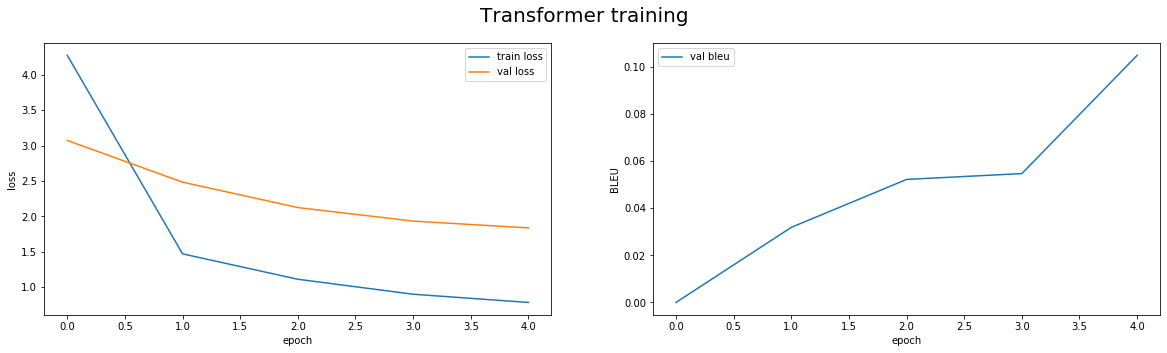

In [19]:
#!g1.1
plot_results(t5_train_loss_list, t5_val_loss_list, t5_val_bleu_list, run_name='Transformer training')

### Итоговое качество модели/примеры переводов

In [22]:
#!g1.1
print(f"Final BLUE score is {t5_val_bleu_list[-1]}.")
print(f"The best BLUE score is {max(t5_val_bleu_list)} on {np.argmax(t5_val_bleu_list) + 1} epoch.")

Final BLUE score is 0.10490708413534929.
The best BLUE score is 0.10490708413534929 on 5 epoch.


In [21]:
#!g1.1
print_demo_translations(t5_model, t5_val_dataloader, t5_dm.source_tokenizer)

BLEU score on the following sentences is 0.0.
* Original sentence	| True translation	| Predicted translation
* is there a restaurant around here that serves local delicacies	| нибудь здесь есть ресторан где подают местные деликатесы	| здесь здесь здесь здесь здесь
* mary broke tom s nose on their first date	| первом свидании мэри разбила тому нос	| и расстаа на на на на на
* who does this suitcase here belong to	| принадлежит этот чемодан	| принадлежит этот чемодан здесь
* tom is the one causing all the problems	| из за тома все проблемы	| том от всех проблемы
* what s the one thing you would have done differently	| бы ты сделал по другому	| чего ты бы бы бы
* what do dogs and wolves have in common	| общего между собаками и волками	| собаки собаки и волк волк
* tom cut himself with a knife this morning	| сегодня утром ножом порезался	| сегодня порезалрезал ножом ножом
* to his surprise the thief turned out to be his own son	| его удивлению вор оказался его собственным сыном	| желание с